<a href="https://colab.research.google.com/github/Aing-HyeonWoo/mitmit/blob/main/realNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. pip 업그레이드 (최신 pip는 의존성 문제를 해결하는 데 더 나음)
!pip install --upgrade pip

# 2. 특정 패키지의 호환 가능한 버전 설치
!pip install numpy==1.26.0 scipy==1.13.3 fsspec==2024.10.0

# 3. spacy 및 관련 패키지 설치
!pip install spacy==3.7.2 en-core-web-sm==3.7.1

# 4. 기타 의존성 패키지 설치
!pip install gensim==4.3.3 langchain==0.3.12 pytensor==2.26.4

# 5. 추가 설치: nltk 및 Convokit
!pip install nltk convokit
!python3 -m spacy download en_core_web_sm


  Using cached numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10
ERROR: Could not find a version that satisfies the requirement scipy==1.13.3 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 1.0.0, 1.0.1, 1.1.0, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.4.0, 1.4.1, 1.5.0, 1.5.1, 1.5.2, 1.5.3, 1.5.4, 1.6.0, 1.6.1, 1.7.2, 1.7.3, 1.8.0rc1, 1.8.0rc2, 1.8.0rc3, 1.8.0rc4, 1.8.0, 1.8.1, 1.9.0rc1, 1.9.0rc2, 1.9.0rc3, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0rc1, 1.10.0rc2, 1.10.0, 1.10.1, 1.11.0rc1, 1.11.0rc2, 1.11.1, 1.11.

In [ ]:
3!pip install jsonlines

In [ ]:
#import nltk
from convokit import Corpus, download
#nltk.download('punkt')
dataset_path = download("movie-corpus")
corpus = Corpus(filename=dataset_path)# import dataset

In [ ]:
import csv
import codecs
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import unicodedata
import random
import itertools
import re
import json
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 데이터 확인
import os
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(dataset_path, "utterances.jsonl"))


b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

In [ ]:
# 데이터 전처리
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            lines[lineObj['lineID']] = lineObj

            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                #convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations

def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        for i in range(len(conversation["lines"]) - 1):
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

# 새 파일에 대한 경로를 정의합니다
datafile = os.path.join(dataset_path, "formatted_movie_lines.txt")

delimiter = '\t'
# 구분자에 대해 unescape 함수를 호출합니다
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# 대사 사전(lines dict)과 대화 사전(conversations dict)을 초기화합니다
lines = {}
conversations = {}
# 대사와 대화를 불러옵니다
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join(dataset_path, "utterances.jsonl"))

# 결과를 새로운 csv 파일로 저장합니다
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# 몇 줄을 예제 삼아 출력해 봅니다
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


In [ ]:
# 단어 -> 인덱스
# 기본 단어 토큰 값
PAD_token = 0  # 짧은 문장을 채울(패딩, PADding) 때 사용할 제로 토큰
SOS_token = 1  # 문장의 시작(SOS, Start Of Sentence)을 나타내는 토큰
EOS_token = 2  # 문장의 끝(EOS, End Of Sentence)을 나태는 토큰

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # SOS, EOS, PAD를 센 것

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # 등장 횟수가 기준 이하인 단어를 정리합니다
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # 사전을 다시 초기화합니다
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # 기본 토큰을 센 것

        for word in keep_words:
            self.addWord(word)

# 전처리
MAX_LENGTH = 10  # 고려할 문장의 최대 길이

# 유니코드 문자열을 아스키로 변환합니다
# https://stackoverflow.com/a/518232/2809427 참고
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자로 만들고, 공백을 넣고, 알파벳 외의 글자를 제거합니다
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# 질의/응답 쌍을 읽어서 voc 객체를 반환합니다
# 질의/응답 쌍을 읽어서 voc 객체를 반환합니다
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # 파일을 읽고, 쪼개어 lines에 저장합니다
    lines = open(datafile, encoding='utf-8').read().strip().split('\n')

    # 각 줄을 쪼개어 pairs에 저장하고 정규화합니다
    pairs = []
    for l in lines:
        parts = l.split('\t')
        if len(parts) == 2:  # 올바른 형식(탭으로 나뉘어진 두 부분)을 가진 줄만 처리
            pairs.append([normalizeString(s) for s in parts])

    voc = Voc(corpus_name)
    return voc, pairs


# 문장의 쌍 'p'에 포함된 두 문장이 모두 MAX_LENGTH라는 기준보다 짧은지를 반환합니다
# 문장의 쌍 'p'에 포함된 두 문장이 모두 MAX_LENGTH라는 기준보다 짧은지를 반환합니다
def filterPair(p):
    # 데이터가 올바르게 포함되어 있는지 확인
    if len(p) != 2:
        return False
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# 조건식 ``filterPair`` 에 따라 pairs를 필터링합니다
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# 앞에서 정의한 함수를 이용하여 만든 voc 객체와 리스트 pairs를 반환합니다
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# voc와 pairs를 읽고 재구성합니다
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, "movie-corpus", datafile, save_dir)
# 검증을 위해 pairs의 일부 내용을 출력해 봅니다
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221085 sentence pairs
Trimmed to 64223 sentence pairs
Counting words...
Counted words: 18066

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


In [ ]:
# 많이 안등장하면 날리기
MIN_COUNT = 3    # 제외할 단어의 기준이 되는 등장 횟수

def trimRareWords(voc, pairs, MIN_COUNT):
    # MIN_COUNT 미만으로 사용된 단어는 voc에서 제외합니다
    voc.trim(MIN_COUNT)
    # 제외할 단어가 포함된 경우를 pairs에서도 제외합니다
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # 입력 문장을 검사합니다
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # 출력 문장을 검사합니다
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # 입출력 문장에 제외하기로 한 단어를 포함하지 않는 경우만을 남겨둡니다
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# voc와 pairs를 정돈합니다
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7828 / 18063 = 0.4334
Trimmed from 64223 pairs to 53057, 0.8261 of total


In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# 입력 시퀀스 텐서에 패딩한 결과와 lengths를 반환합니다
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# 패딩한 목표 시퀀스 텐서, 패딩 마스크, 그리고 최대 목표 길이를 반환합니다
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# 입력 배치를 이루는 쌍에 대한 모든 아이템을 반환합니다
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# 검증용 예시
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[   8,  128, 3058, 3028,  175],
        [ 111,   11,  104,   14,   10],
        [ 135,  381,  269,    2,    2],
        [ 592, 1001,   36,    0,    0],
        [  24,   49,   14,    0,    0],
        [ 197,   72,    2,    0,    0],
        [  87,   14,    0,    0,    0],
        [  14,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 8, 6, 3, 3])
target_variable: tensor([[   8, 2397,   19,  213,   85],
        [ 111,   10,    4, 2489,  105],
        [  14,   85,   24,    6, 7093],
        [   2,   31,  265,    2,   17],
        [   0,   37,   10,    0,  178],
        [   0,   50,    2,    0,   14],
        [   0,   44,    0,    0,    3],
        [   0,   10,    0,    0,  276],
        [   0,    2,    0,    0,   14],
        [   0,    0,    0,    0,    2]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # GRU를 초기화합니다. input_size와 hidden_size 매개변수는 둘 다 'hidden_size'로
        # 둡니다. 이는 우리 입력의 크기가 hideen_size 만큼의 피처를 갖는 단어 임베딩이기
        # 때문입니다.
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # 단어 인덱스를 임베딩으로 변환합니다
        embedded = self.embedding(input_seq)
        # RNN 모듈을 위한 패딩된 배치 시퀀스를 패킹합니다
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # GRU로 포워드 패스를 수행합니다
        outputs, hidden = self.gru(packed, hidden)
        # 패딩을 언패킹합니다
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # 양방향 GRU의 출력을 합산합니다
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # 출력과 마지막 은닉 상태를 반환합니다
        return outputs, hidden


# Luong 어텐션 레이어
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Attention 가중치(에너지)를 제안된 방법에 따라 계산합니다
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # max_length와 batch_size의 차원을 뒤집습니다
        attn_energies = attn_energies.t()

        # 정규화된 softmax 확률 점수를 반환합니다 (차원을 늘려서)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # 참조를 보존해 둡니다
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # 레이어를 정의합니다
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # 주의: 한 단위 시간에 대해 한 단계(단어)만을 수행합니다
        # 현재의 입력 단어에 대한 임베딩을 구합니다
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # 무방향 GRU로 포워드 패스를 수행합니다
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # 현재의 GRU 출력을 바탕으로 어텐션 가중치를 계산합니다
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # 인코더 출력에 어텐션을 곱하여 새로운 "가중치 합" 문맥 벡터를 구합니다
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Luong의 논문에 나온 식 5를 이용하여 가중치 문맥 벡터와 GRU 출력을 결합합니다
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Luong의 논문에 나온 식 6을 이용하여 다음 단어를 예측합니다
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # 출력과 마지막 은닉 상태를 반환합니다
        return output, hidden

In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # 제로 그라디언트
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # device 옵션을 설정합니다
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # RNN 패킹의 길이는 항상 CPU에 위치해야 합니다
    lengths = lengths.to("cpu")

    # 변수를 초기화합니다
    loss = 0
    print_losses = []
    n_totals = 0

    # 인코더로 포워드 패스를 수행합니다
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # 초기 디코더 입력을 생성합니다(각 문장을 SOS 토큰으로 시작합니다)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # 디코더의 초기 은닉 상태를 인코더의 마지막 은닉 상태로 둡니다
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # 이번 반복에서 teacher forcing을 사용할지를 결정합니다
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # 배치 시퀀스를 한 번에 하나씩 디코더로 포워드 패스합니다
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing 사용: 다음 입력을 현재의 목표로 둡니다
            decoder_input = target_variable[t].view(1, -1)
            # 손실을 계산하고 누적합니다
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing 미사용: 다음 입력을 디코더의 출력으로 둡니다
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # 손실을 계산하고 누적합니다
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # 역전파를 수행합니다
    loss.backward()

    # 그라디언트 클리핑: 그라디언트를 제자리에서 수정합니다
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # 모델의 가중치를 수정합니다
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [ ]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    loss_list = []
    # 각 단계에 대한 배치를 읽어옵니다
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # 초기화
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if not loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # 학습 루프
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # 배치에서 각 필드를 읽어옵니다
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # 배치에 대해 학습을 한 단계 진행합니다
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # 경과를 출력합니다
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            loss_list.append(print_loss_avg)
            print_loss = 0

        # Checkpoint를 저장합니다
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

    return loss_list


In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # 인코더 모델로 입력을 포워드 패스합니다
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # 인코더의 마지막 은닉 레이어가 디코더의 첫 번째 은닉 레이어의 입력이 되도록 준비합니다
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # 디코더의 첫 번째 입력을 SOS_token으로 초기화합니다
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # 디코더가 단어를 덧붙여 나갈 텐서를 초기화합니다
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # 반복적으로 각 단계마다 하나의 단어 토큰을 디코딩합니다
        for _ in range(max_length):
            # 디코더로의 포워드 패스를 수행합니다
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # 가장 가능성 높은 단어 토큰과 그 softmax 점수를 구합니다
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # 토큰과 점수를 기록합니다
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # 현재의 토큰을 디코더의 다음 입력으로 준비시킵니다(차원을 증가시켜서)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # 단어 토큰과 점수를 모아서 반환합니다
        return all_tokens, all_scores

In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### 입력 시퀀스를 배치 형태로 만듭니다
    # 단어 -> 인덱스
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # lengths 텐서를 만듭니다
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # 배치의 차원을 뒤집어서 모델이 사용하는 형태로 만듭니다
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # 적절한 디바이스를 사용합니다
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # searcher를 이용하여 문장을 디코딩합니다
    tokens, scores = searcher(input_batch, lengths, max_length)
    # 인덱스 -> 단어
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # 입력 문장을 받아옵니다
            input_sentence = input('> ')
            # 종료 조건인지 검사합니다
            if input_sentence == 'q' or input_sentence == 'quit': break
            # 문장을 정규화합니다
            input_sentence = normalizeString(input_sentence)
            # 문장을 평가합니다
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # 응답 문장을 형식에 맞춰 출력합니다
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [ ]:
# 모델을 설정합니다
model_name = 'cb_model'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# 불러올 checkpoint를 설정합니다. 처음부터 시작할 때는 None으로 둡니다.
loadFilename = None
checkpoint_iter = 4000

loadFilename = os.path.join(save_dir, model_name, "movie-corpus",
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))

In [ ]:
# ``loadFilename`` 이 존재하는 경우에는 모델을 불러옵니다
if not loadFilename:
    # 모델을 학습할 때와 같은 기기에서 불러오는 경우
    checkpoint = torch.load(loadFilename)
    # GPU에서 학습한 모델을 CPU로 불러오는 경우
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# 단어 임베딩을 초기화합니다
embedding = nn.Embedding(voc.num_words, hidden_size)
if not loadFilename:
    embedding.load_state_dict(embedding_sd)
# 인코더 및 디코더 모델을 초기화합니다
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if not loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# 적절한 디바이스를 사용합니다
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
# 학습 및 최적화 설정
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 15000
print_every = 1
save_every = 500

# Dropout 레이어를 학습 모드로 둡니다
encoder.train()
decoder.train()

# Optimizer를 초기화합니다
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if not loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# CUDA가 있으면 CUDA를 설정합니다
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# 학습 단계를 수행합니다
print("Starting Training!")
loss = trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, "movie-corpus", loadFilename)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Iteration: 10001; Percent complete: 66.7%; Average loss: 1.2362
Iteration: 10002; Percent complete: 66.7%; Average loss: 1.2686
Iteration: 10003; Percent complete: 66.7%; Average loss: 1.3680
Iteration: 10004; Percent complete: 66.7%; Average loss: 1.3441
Iteration: 10005; Percent complete: 66.7%; Average loss: 1.3902
Iteration: 10006; Percent complete: 66.7%; Average loss: 1.2081
Iteration: 10007; Percent complete: 66.7%; Average loss: 1.4220
Iteration: 10008; Percent complete: 66.7%; Average loss: 1.2522
Iteration: 10009; Percent complete: 66.7%; Average loss: 1.1798
Iteration: 10010; Percent complete: 66.7%; Average loss: 1.4544
Iteration: 10011; Percent complete: 66.7%; Average loss: 1.2008
Iteration: 10012; Percent complete: 66.7%; Average loss: 1.2792
Iteration: 10013; Percent complete: 66.8%; Average loss: 1.3331
Iteration: 10014; Percent complete: 66.8%; Average loss: 1.2653
Iteration: 10015; Percent complete: 66.8%; Average loss: 1.2709
Iter

In [ ]:
# Dropout 레이어를 평가( ``eval`` ) 모드로 설정합니다
encoder.eval()
decoder.eval()

# 탐색 모듈을 초기화합니다
searcher = GreedySearchDecoder(encoder, decoder)

# 채팅을 시작합니다 (다음 줄의 주석을 제거하면 시작해볼 수 있습니다)
evaluateInput(encoder, decoder, searcher, voc)

> hello
Bot: hello . . . . .
> what are you doing
Bot: saving your life . i m busy .
> it's trash
Bot: what ? what s happening ?
> your face
Bot: do you want to kill it ?
> yes
Bot: and you think i m not ?
> q


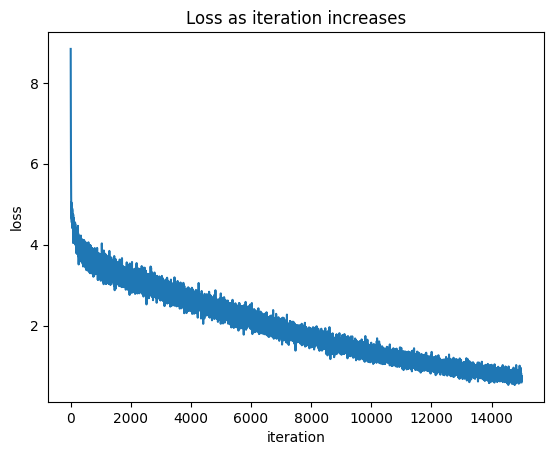

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1, 15001)
fig = plt.figure()
plt.plot(x, loss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss as iteration increases')
plt.show()

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

# GreedySearchDecoder 객체 저장
torch.save(searcher, 'searcher.pth')